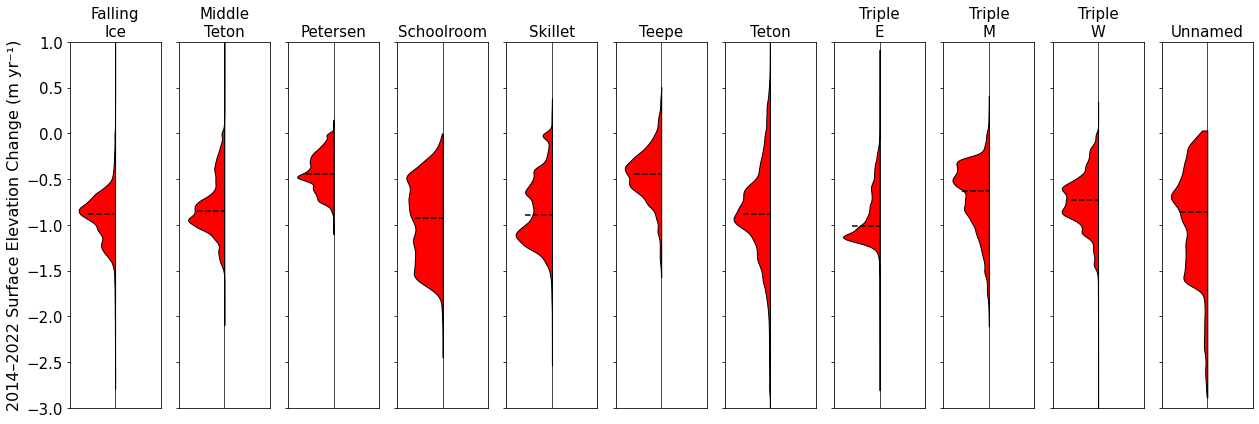

In [19]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


shapefile_fp = "teton_outline_final.shp"
raster_fp = "Elevation_Change_CirqueGlacier_2014_2022.tif"
year_diff = 8

#Custom name mapping for plot labels ---
name_mapping = {
    "Teepee": "Teepe",
    "Triple_west": "Triple W",
    "Triple_middle": "Triple M",
    "Triple_east": "Triple E",
    "Falling_ice": "Falling Ice",
    "peterson": "Petersen",
    "Middle_teton_final": "Middle Teton",
    "schoolroom": "Schoolroom"
}

#Load shapefile
gdf = gpd.read_file(shapefile_fp)

#Extract thinning data per glacier
thinning_data = {}
with rasterio.open(raster_fp) as src:
    raster_crs = src.crs
    if gdf.crs.to_epsg() != raster_crs.to_epsg():
        gdf = gdf.to_crs(raster_crs.to_epsg())

    for _, row in gdf.iterrows():
        original_name = row["Name"]
        display_name = name_mapping.get(original_name, original_name)  # fallback to original if no mapping

        geom = [row["geometry"]]
        try:
            clipped, _ = mask(src, geom, crop=True)
            array = clipped[0].astype(np.float32)
            array[array == src.nodata] = np.nan
            values = array[~np.isnan(array)] / year_diff
            if values.size > 0:
                thinning_data[display_name] = values
        except Exception as e:
            print(f"Skipping {original_name} due to error: {e}")
            continue

# Sort glaciers alphabetically by display name
glaciers = sorted(thinning_data.keys())

#Plot setup
fig, axes = plt.subplots(1, len(glaciers), figsize=(1.6 * len(glaciers), 6), sharey=True)

for i, (glacier, ax) in enumerate(zip(glaciers, axes)):
    values = thinning_data[glacier]

    # KDE for half violin
    kde = gaussian_kde(values)
    y_vals = np.linspace(min(values), max(values), 200)
    density = kde(y_vals)
    density = density / density.max() * 0.4  # normalize and scale width

    # Plot half violin (left side)
    ax.fill_betweenx(y_vals, 0, -density, facecolor='red', edgecolor='black', alpha=1)

    # Plot median
    median = np.median(values)
    ax.hlines(median, -0.3, 0.0, colors='black', linestyles='dashed', linewidth=1.5)

    # Format title
    label_lines = glacier.split(" ")
    ax.set_title("\n".join(label_lines), fontsize=15)

    ax.set_xticks([])
    ax.set_xlim(-0.5, 0.5)
    ax.axvline(0, color='black', linewidth=0.7)
    ax.tick_params(axis='x', bottom=False)
    ax.grid(False)

# Y-axis shared
axes[0].set_ylabel("2014–2022 Surface Elevation Change (m yr⁻¹)", fontsize=16)
for ax in axes:
    ax.set_ylim(-3, 1)
    ax.tick_params(axis='y', labelsize=15)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()


In [20]:
print("Median Surface Elevation Change per Glacier (2014–2022):")
for glacier, values in thinning_data.items():
    median_val = np.median(values)
    print(f"{glacier}: {median_val:.2f} m yr⁻¹")


Median Surface Elevation Change per Glacier (2014–2022):
Teton: -0.88 m yr⁻¹
Teepe: -0.44 m yr⁻¹
Triple W: -0.73 m yr⁻¹
Falling Ice: -0.88 m yr⁻¹
Triple M: -0.63 m yr⁻¹
Triple E: -1.01 m yr⁻¹
Skillet: -0.89 m yr⁻¹
Unnamed: -0.86 m yr⁻¹
Petersen: -0.44 m yr⁻¹
Schoolroom: -0.92 m yr⁻¹
Middle Teton: -0.85 m yr⁻¹
